## - import

In [ ]:
import os
import glob
import time
import random
import json
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import warnings
warnings.filterwarnings(action='ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### configuration

In [ ]:
ROOT = "/content/drive/MyDrive/Final_Project/g25_dataset"
TRAIN_PATH = ROOT + "/train/images"
VALID_PATH = ROOT + "/valid/images"
TEST_PATH  = ROOT + "/test/images"
TRAIN_JSON = ROOT + "/train/annotations/g25_instances_train_sample.json"
VALID_JSON = ROOT + "/valid/annotations/g25_instances_valid_half.json"
TEST_JSON  = ROOT + "/test/annotations/g25_instances_test.json"

BEST_MODEL = True
BEST_MODEL_PATH = "/content/drive/MyDrive/FP/checkpoints/best_model_7-10_0.22.pth"

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

# Will be used to normalize pictures
# Normalize to resnet mean and std if True.
NORMALIZE = False
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 8

MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
LEARNING_RATE = 0.001
USE_SCHEDULER = True
NUM_EPOCHS = 10

# Confidence required for a pixel to be kept for a mask
MASK_THRESHOLD = 0.5
MASK_THRESHOLD_DICT = {1: 0.5, 2: 0.75}
MIN_SCORE_DICT = {1: 0.59, 2: 0.75, 3: 0.5}

cpu


## - dataset

### 1. custom dataset

In [ ]:
class SolarPanelDataset(Dataset):
    def __init__(self, image_dir, ann_file, transforms=None):
        self.image_dir = image_dir
        self.transforms = transforms
        # COCO
        self.coco = COCO(ann_file)
        self.ids = self.coco.getImgIds()
        self.catid_to_name = {cat['id']: cat['name'] for cat in self.coco.loadCats(self.coco.getCatIds())}

        # self.ids = list(self.coco.imgs.keys())
        # self.annotations = {ann['image_id']: [] for ann in self.coco.dataset['annotations']}
        # for ann in self.coco.dataset['annotations']:
        #     self.annotations[ann['image_id']].append(ann)

        # JSON
        # with open(ann_file, 'r') as f:
        #     self.coco = json.load(f)
        # self.ids = [img['id'] for img in self.coco['images']]
        # self.image_info = {img['id']: img for img in self.coco['images']}
        # self.annotations = {ann['image_id']: [] for ann in self.coco['annotations']}
        # for ann in self.coco['annotations']:
        #     self.annotations[ann['image_id']].append(ann)

    def __getitem__(self, index):
        img_id = self.ids[index]
        # img_info = self.image_info[img_id]
        img_info = self.coco.imgs[img_id]
        ann_info = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))

        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        areas = []
        labels = []
        masks = [] # 한 이미지에 3개의 객체가 있으면, masks 텐서는 각각 객체에 대응하는 3개의 2D 마스크를 포함해야 함.
        for ann in ann_info:
            xmin, ymin, width, height = ann['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
            areas.append(ann['area'])
            labels.append(ann['category_id'])
            segm = ann['segmentation']
            masks.append(self.convert_to_mask(segm, img.size))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8) # (N, height, width) 크기의 텐서로, N은 이미지 내 객체의 수를 의미
        # iscrowd = torch.as_tensor([ann['iscrowd'] for ann in ann_info], dtype=torch.int64)
        iscrowd = torch.zeros((len(ann_info),), dtype=torch.int64)
        image_id = torch.tensor([img_id])

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'area': areas,
            'image_id': image_id,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

    def convert_to_mask(self, segment, image_size):
        mask = Image.new('L', image_size, 0)
        ImageDraw.Draw(mask).polygon(segment, outline=1, fill=1)
        return mask # <PIL.Image.Image image mode=L size=512x512>

### 2. transforms

In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class RandomHorizontalFlip: # x, width
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if np.random.rand() < self.prob:
            image = F.hflip(image)
            target["boxes"] = self.flip_boxes(target["boxes"], image.shape[-1])
            target["masks"] = target["masks"].flip(-1) # PIL Iamge Object
        return image, target

    def flip_boxes(self, boxes, width):
        boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
        return boxes

class RandomVerticalFlip: # y, height
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if np.random.rand() < self.prob:
            image = F.vflip(image)
            target["boxes"] = self.flip_boxes(target["boxes"], image.shape[-2])
            target["masks"] = target["masks"].flip(-2)
        return image, target

    def flip_boxes(self, boxes, height):
        boxes[:, [1, 3]] = height - boxes[:, [3, 1]]
        return boxes

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # Data augmentation for training dataset
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(RandomVerticalFlip(0.5))

    return Compose(transforms)

In [ ]:
train_dataset = SolarPanelDataset(image_dir=TRAIN_PATH, ann_file=TRAIN_JSON, transforms=get_transform(train=True))
len(train_dataset)#, train_dataset[0]

loading annotations into memory...
Done (t=2.69s)
creating index...
index created!


10632

In [ ]:
train_g25_label = pd.read_csv("/content/drive/MyDrive/Final_Project/dataset/train/label/solar_generation_25cm_label.csv")
train_g25_label.head()

file_name  object_id      area   class_name annotation_type  \
0  S2021SBA36707005040          1    Ground  Solar panel         polygon   
1  S2021SBA36707005040          2    Ground  Solar panel         polygon   
2  S2021SBA36707005040          3    Ground  Solar panel         polygon   
3  S2021SBA36707005040          4    Ground  Solar panel         polygon   
4  S2021SBA36709056004          1  Building  Solar panel         polygon   

                                              points  
0  [345.8538775119653, 13.721356486247174, 344.46...  
1  [413.10770286341096, 19.927455059114532, 411.4...  
2  [350.2868069455618, 74.38912555083328, 348.766...  
3  [398.4157222827259, 138.3499287830206, 396.262...  
4  [10.249081980790393, 278.4427509792365, 8.9084...

In [ ]:
valid_dataset = SolarPanelDataset(image_dir=VALID_PATH, ann_file=VALID_JSON, transforms=get_transform(train=False))
len(valid_dataset)#, valid_dataset[0]

loading annotations into memory...
Done (t=1.18s)
creating index...
index created!


1181

In [ ]:
test_dataset = SolarPanelDataset(image_dir=TEST_PATH, ann_file=TEST_JSON, transforms=get_transform(train=False))
len(test_dataset)#, test_dataset[0]

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


1181

In [ ]:
# JSON
with open(VALID_JSON, 'r') as f:
    valid_info = json.load(f)
valid_info

{'info': {'description': 'validation solar_generation_25cm',
  'data_collect_year': '2022'},
 'images': [{'id': 0,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA36701009036.tif',
   'object_num': 1},
  {'id': 1,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37608091002.tif',
   'object_num': 1},
  {'id': 2,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37610010053.tif',
   'object_num': 1},
  {'id': 3,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37611079011.tif',
   'object_num': 1},
  {'id': 4,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA36702001005.tif',
   'object_num': 1},
  {'id': 5,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37608066004.tif',
   'object_num': 1},
  {'id': 6,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37612071003.tif',
   'object_num': 3},
  {'id': 7,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37612001080.tif',
   'object_num': 4},
  {'id': 

In [ ]:
# COCO
valid_coco = COCO(VALID_JSON)
valid_coco

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
valid_coco.dataset

{'info': {'description': 'validation solar_generation_25cm',
  'data_collect_year': '2022'},
 'images': [{'id': 0,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA36701009036.tif',
   'object_num': 1},
  {'id': 1,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37608091002.tif',
   'object_num': 1},
  {'id': 2,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37610010053.tif',
   'object_num': 1},
  {'id': 3,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37611079011.tif',
   'object_num': 1},
  {'id': 4,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA36702001005.tif',
   'object_num': 1},
  {'id': 5,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37608066004.tif',
   'object_num': 1},
  {'id': 6,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37612071003.tif',
   'object_num': 3},
  {'id': 7,
   'width': 512,
   'height': 512,
   'file_name': 'S2021SAA37612001080.tif',
   'object_num': 4},
  {'id': 

In [ ]:
valid_coco.dataset['info']

{'description': 'validation solar_generation_25cm',
 'data_collect_year': '2022'}

In [ ]:
len(valid_coco.dataset['annotations'])

4592

In [ ]:
valid_coco.getAnnIds(imgIds=179)

[330]

In [ ]:
ids = list(valid_coco.imgs.keys())
print(ids)
print(ids[-1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
ids = valid_coco.getImgIds()
print(ids)
print(ids[-1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
idxes = [img['id'] for img in valid_info['images']]
print(idxes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
valid_coco.imgs

{0: {'id': 0,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA36701009036.tif',
  'object_num': 1},
 1: {'id': 1,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA37608091002.tif',
  'object_num': 1},
 2: {'id': 2,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA37610010053.tif',
  'object_num': 1},
 3: {'id': 3,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA37611079011.tif',
  'object_num': 1},
 4: {'id': 4,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA36702001005.tif',
  'object_num': 1},
 5: {'id': 5,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA37608066004.tif',
  'object_num': 1},
 6: {'id': 6,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA37612071003.tif',
  'object_num': 3},
 7: {'id': 7,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA37612001080.tif',
  'object_num': 4},
 8: {'id': 8,
  'width': 512,
  'height': 512,
  'file_name': 'S2021SAA37612002044.tif',
  'object_num': 2},
 9: {'id': 9,
  'wi

In [ ]:
valid_coco.imgs[7]

{'id': 7,
 'width': 512,
 'height': 512,
 'file_name': 'S2021SAA37612001080.tif',
 'object_num': 4}

In [ ]:
img_info = valid_coco.imgs[7]
img_info

{'id': 7,
 'width': 512,
 'height': 512,
 'file_name': 'S2021SAA37612001080.tif',
 'object_num': 4}

In [ ]:
image_info = valid_info['images'][7]
image_info

{'id': 7,
 'width': 512,
 'height': 512,
 'file_name': 'S2021SAA37612001080.tif',
 'object_num': 4}

In [ ]:
valid_coco.getAnnIds(imgIds=7)

[9, 10, 11, 12]

In [ ]:
valid_coco.loadAnns(valid_coco.getAnnIds(imgIds=7))

[{'id': 9,
  'image_id': 7,
  'category_id': 1,
  'segmentation': [425.7236987967465,
   286.78777399482885,
   424.36208657222886,
   299.13954203152446,
   443.5467399647386,
   301.58475519646635,
   445.7741079713558,
   289.03049915916915,
   425.7236987967465,
   286.78777399482885],
  'bbox': [424.36208657222886,
   286.78777399482885,
   21.412021399126957,
   14.796981201637493],
  'area': 316.8332781319413,
  'iscrowd': 0},
 {'id': 10,
  'image_id': 7,
  'category_id': 1,
  'segmentation': [230.8594427818788,
   372.7151050413979,
   227.4790038712881,
   388.12361728502066,
   243.43782012361163,
   391.5040561956113,
   246.81825903420236,
   376.6458479606894,
   230.8594427818788,
   372.7151050413979],
  'bbox': [227.4790038712881,
   372.7151050413979,
   19.33925516291424,
   18.788951154213407],
  'area': 363.36432061486516,
  'iscrowd': 0},
 {'id': 11,
  'image_id': 7,
  'category_id': 1,
  'segmentation': [88.4148938867723,
   157.42971988067927,
   84.6218312613303

In [ ]:
annots = {ann['image_id']: [] for ann in valid_coco.dataset['annotations']}
for ann in valid_coco.dataset['annotations']:
    annots[ann['image_id']].append(ann)
annots[7]

[{'id': 9,
  'image_id': 7,
  'category_id': 1,
  'segmentation': [425.7236987967465,
   286.78777399482885,
   424.36208657222886,
   299.13954203152446,
   443.5467399647386,
   301.58475519646635,
   445.7741079713558,
   289.03049915916915,
   425.7236987967465,
   286.78777399482885],
  'bbox': [424.36208657222886,
   286.78777399482885,
   21.412021399126957,
   14.796981201637493],
  'area': 316.8332781319413,
  'iscrowd': 0},
 {'id': 10,
  'image_id': 7,
  'category_id': 1,
  'segmentation': [230.8594427818788,
   372.7151050413979,
   227.4790038712881,
   388.12361728502066,
   243.43782012361163,
   391.5040561956113,
   246.81825903420236,
   376.6458479606894,
   230.8594427818788,
   372.7151050413979],
  'bbox': [227.4790038712881,
   372.7151050413979,
   19.33925516291424,
   18.788951154213407],
  'area': 363.36432061486516,
  'iscrowd': 0},
 {'id': 11,
  'image_id': 7,
  'category_id': 1,
  'segmentation': [88.4148938867723,
   157.42971988067927,
   84.6218312613303

In [ ]:
annots

{0: [{'id': 0,
   'image_id': 0,
   'category_id': 1,
   'segmentation': [412.13995644469674,
    67.30287979815931,
    391.11725943258506,
    91.30751481047344,
    408.1143310567987,
    108.15548932310736,
    430.1807098372748,
    83.85266095748852,
    412.13995644469674,
    67.30287979815931],
   'bbox': [391.11725943258506,
    67.30287979815931,
    39.06345040468972,
    40.85260952494805],
   'area': 1595.8438860799629,
   'iscrowd': 0}],
 1: [{'id': 1,
   'image_id': 1,
   'category_id': 1,
   'segmentation': [30.15069509013275,
    224.97618784789483,
    27.073366661490553,
    249.37501707457182,
    103.67690499161554,
    257.9475798913263,
    106.64434016533022,
    233.8784636258328,
    30.15069509013275,
    224.97618784789483],
   'bbox': [27.073366661490553,
    224.97618784789483,
    79.57097350383967,
    32.97139204343148],
   'area': 2623.565762672596,
   'iscrowd': 0}],
 2: [{'id': 2,
   'image_id': 2,
   'category_id': 1,
   'segmentation': [268.101564

In [ ]:
anns = valid_coco.anns
anns

{0: {'id': 0,
  'image_id': 0,
  'category_id': 1,
  'segmentation': [412.13995644469674,
   67.30287979815931,
   391.11725943258506,
   91.30751481047344,
   408.1143310567987,
   108.15548932310736,
   430.1807098372748,
   83.85266095748852,
   412.13995644469674,
   67.30287979815931],
  'bbox': [391.11725943258506,
   67.30287979815931,
   39.06345040468972,
   40.85260952494805],
  'area': 1595.8438860799629,
  'iscrowd': 0},
 1: {'id': 1,
  'image_id': 1,
  'category_id': 1,
  'segmentation': [30.15069509013275,
   224.97618784789483,
   27.073366661490553,
   249.37501707457182,
   103.67690499161554,
   257.9475798913263,
   106.64434016533022,
   233.8784636258328,
   30.15069509013275,
   224.97618784789483],
  'bbox': [27.073366661490553,
   224.97618784789483,
   79.57097350383967,
   32.97139204343148],
  'area': 2623.565762672596,
  'iscrowd': 0},
 2: {'id': 2,
  'image_id': 2,
  'category_id': 1,
  'segmentation': [268.10156484533724,
   197.49886253208214,
   261.7810

In [ ]:
boxes = []
labels = []
masks = []
for ann in valid_coco.loadAnns(valid_coco.getAnnIds(imgIds=7)):
    print(ann)
    xmin, ymin, width, height = ann['bbox']
    boxes.append([xmin, ymin, xmin + width, ymin + height])
    labels.append(ann['category_id'])
    segm = ann['segmentation']
    mask = Image.new('L', (512, 512), 0)
    ImageDraw.Draw(mask).polygon(segm, outline=1, fill=1)
    # masks.append(np.array(mask, dtype=np.uint8))
    # <ipython-input-4-df0023ccaaa6>:36: UserWarning:
    # Creating a tensor from a list of numpy.ndarrays is extremely slow.
    # Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor.
    # masks = torch.as_tensor(masks, dtype=torch.uint8) # (obj_Num, img_H, img_W)
    masks.append(mask)
boxes, labels, masks

{'id': 9, 'image_id': 7, 'category_id': 1, 'segmentation': [425.7236987967465, 286.78777399482885, 424.36208657222886, 299.13954203152446, 443.5467399647386, 301.58475519646635, 445.7741079713558, 289.03049915916915, 425.7236987967465, 286.78777399482885], 'bbox': [424.36208657222886, 286.78777399482885, 21.412021399126957, 14.796981201637493], 'area': 316.8332781319413, 'iscrowd': 0}
{'id': 10, 'image_id': 7, 'category_id': 1, 'segmentation': [230.8594427818788, 372.7151050413979, 227.4790038712881, 388.12361728502066, 243.43782012361163, 391.5040561956113, 246.81825903420236, 376.6458479606894, 230.8594427818788, 372.7151050413979], 'bbox': [227.4790038712881, 372.7151050413979, 19.33925516291424, 18.788951154213407], 'area': 363.36432061486516, 'iscrowd': 0}
{'id': 11, 'image_id': 7, 'category_id': 1, 'segmentation': [88.4148938867723, 157.42971988067927, 84.62183126133034, 176.39503300788908, 104.65698256494687, 180.47986968144198, 107.96375511020398, 160.9310084580103, 101.3502100

([[424.36208657222886,
   286.78777399482885,
   445.7741079713558,
   301.58475519646635],
  [227.4790038712881,
   372.7151050413979,
   246.81825903420236,
   391.5040561956113],
  [84.62183126133034,
   157.42971988067927,
   107.96375511020398,
   180.47986968144198],
  [152.297421924172,
   36.86461633318621,
   174.08321751645406,
   50.48073857836251]],
 [1, 1, 1, 1],
 [<PIL.Image.Image image mode=L size=512x512>,
  <PIL.Image.Image image mode=L size=512x512>,
  <PIL.Image.Image image mode=L size=512x512>,
  <PIL.Image.Image image mode=L size=512x512>],
 [])

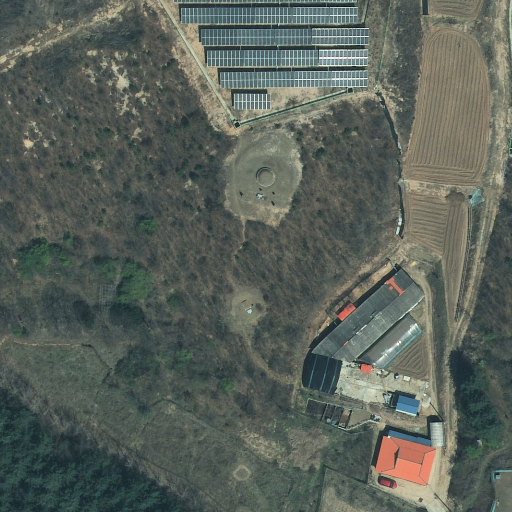

In [ ]:
image = Image.open(os.path.join(VALID_PATH, image_info['file_name'])).convert("RGB")
image

In [ ]:
image.size, image.width, image.height

((512, 512), 512, 512)

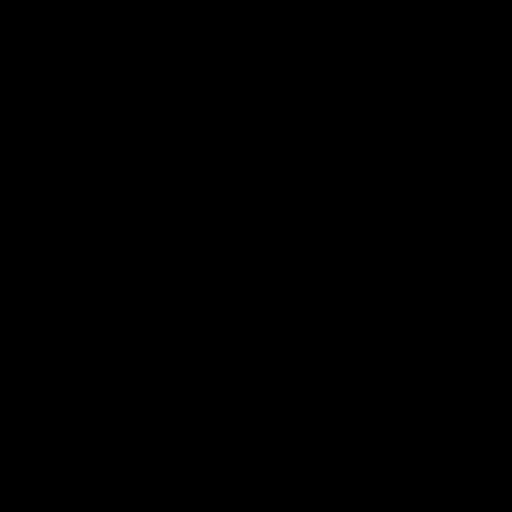

In [ ]:
mask_raw = Image.new(mode='L', size=image.size, color=0) # mode='RGB', size=image.size, color=(0, 0, 0)
mask_raw

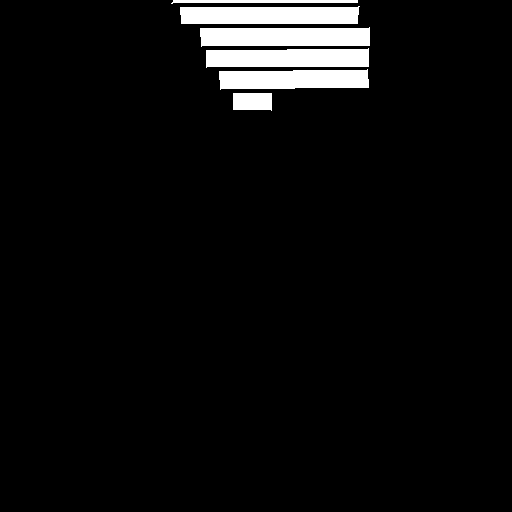

In [ ]:
from PIL import ImageDraw

mask = Image.new('L', image.size, 0)
for ann in annots[4]:
    segm = ann['segmentation']
    ImageDraw.Draw(mask).polygon(segm, outline=255, fill=255)
display(mask)

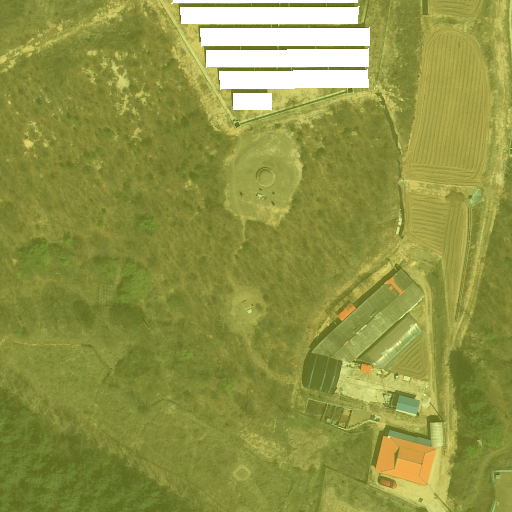

In [ ]:
mask_rgb = mask.convert('RGB')

# 원본 이미지와 마스크를 합침 (마스크가 흰색인 부분에 빨간색 덧씌우기)
combined_image = Image.blend(image, Image.new('RGB', image.size, (255, 255, 0)), alpha=0.3)
combined_image.paste(mask_rgb, (0, 0), mask)
# image.paste(mask_rgb, (0, 0), mask)

# 결과 이미지 출력
display(combined_image)
# display(image)

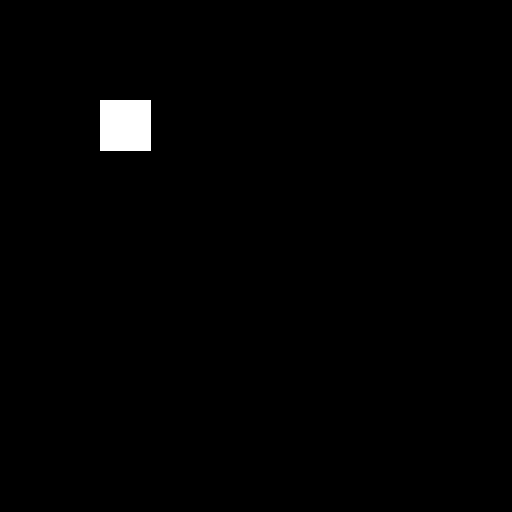

In [ ]:
from PIL import Image, ImageDraw

# 빈 마스크 생성 (흑백 이미지, 크기는 512x512)
mask = Image.new('L', (512, 512), 0)

# 다각형의 꼭지점 좌표 (예시 좌표)
segm = [100, 100, 150, 100, 150, 150, 100, 150]

# 드로잉 객체 생성
draw = ImageDraw.Draw(mask)

# 다각형 그리기
draw.polygon(segm, outline=255, fill=255)

# 마스크 출력
display(mask)

In [ ]:
torch.ones((len(annots[7]),), dtype=torch.int64)

tensor([1, 1, 1, 1])

In [ ]:
torch.zeros((len(annots[7]),), dtype=torch.int64)

tensor([0, 0, 0, 0])

In [ ]:
labels = torch.as_tensor(labels, dtype=torch.int64)
labels, labels.shape

(tensor([1, 1, 1, 1]), torch.Size([4]))

In [ ]:
boxes = torch.as_tensor(boxes, dtype=torch.float32)
boxes, boxes.shape

(tensor([[424.3621, 286.7878, 445.7741, 301.5847],
         [227.4790, 372.7151, 246.8183, 391.5041],
         [ 84.6218, 157.4297, 107.9638, 180.4799],
         [152.2974,  36.8646, 174.0832,  50.4807]]),
 torch.Size([4, 4]))

In [ ]:
masks = torch.as_tensor(masks, dtype=torch.uint8)
masks.shape, masks.dtype

(torch.Size([4, 512, 512]), torch.uint8)

In [ ]:
masks_narr = np.array(masks)  # 리스트를 numpy array로 변환
print(masks_narr.shape, masks_narr.dtype)
masks_tensor = torch.as_tensor(np.array(masks), dtype=torch.uint8)  # numpy array를 tensor로 변환
masks_tensor.shape, masks_tensor.dtype

(6, 512, 512) uint8


(torch.Size([6, 512, 512]), torch.uint8)

In [ ]:
masks

[<PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>]

- Horizontal Flip

	수평, 가로

	![horizontal_flip](https://github.com/ElaYJ/supplement/assets/153154981/9008bc1a-8af1-4227-9888-caccdd49c3b8)

In [ ]:
# mask horizontal flip - x, width
flip_masks = masks_tensor.flip(-1).numpy()
flip_masks.shape, flip_masks[0].shape

((6, 512, 512), (512, 512))

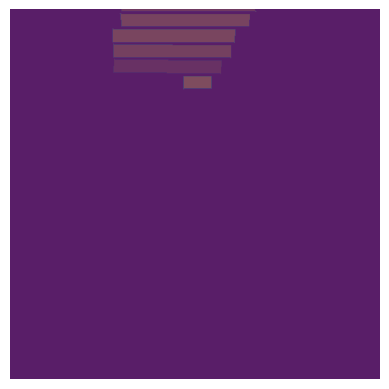

In [ ]:
plt.imshow(flip_masks[0], alpha=0.5)  # 첫 번째 이미지를 투명도를 조정하여 그립니다.
plt.imshow(flip_masks[1], alpha=0.4)  # 두 번째 이미지를 투명도를 조정하여 그립니다.
plt.imshow(flip_masks[2], alpha=0.3)  # 세 번째 이미지를 투명도를 조정하여 그립니다.
plt.imshow(flip_masks[3], alpha=0.2)  # 네 번째 이미지를 투명도를 조정하여 그립니다.
plt.imshow(flip_masks[4], alpha=0.1)  # 다섯 번째 이미지를 투명도를 조정하여 그립니다.
plt.imshow(flip_masks[5], alpha=0.2)

plt.axis('off')  # 축을 제거합니다.
plt.show()

- Vertical Flip

	수직, 세로

	![vertical_flip](https://github.com/ElaYJ/supplement/assets/153154981/ecb28665-28fd-4969-a2e2-48f5a22ee329)
	![HnV_flip](https://github.com/ElaYJ/supplement/assets/153154981/68633857-c061-46a4-ba65-d0baacab0b9c)

In [ ]:
# mask vertical flip - y, height
flip_masks = masks_tensor.flip(-2).numpy()
flip_masks.shape, flip_masks[0].shape

((6, 512, 512), (512, 512))

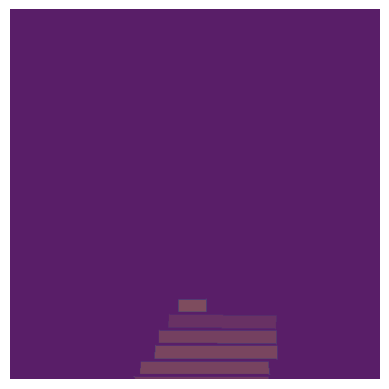

In [ ]:
plt.imshow(flip_masks[0], alpha=0.5)
plt.imshow(flip_masks[1], alpha=0.4)
plt.imshow(flip_masks[2], alpha=0.3)
plt.imshow(flip_masks[3], alpha=0.2)
plt.imshow(flip_masks[4], alpha=0.1)
plt.imshow(flip_masks[5], alpha=0.2)

plt.axis('off')  # 축을 제거합니다.
plt.show()

### 3. dataloader

In [ ]:
train_dloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
len(train_dloader)

1329

In [ ]:
image, targets = next(iter(train_dloader))
len(image), len(targets), image[0], targets[0]

(12,
 12,
 tensor([[[0.4431, 0.4549, 0.4392,  ..., 0.2314, 0.2039, 0.2118],
          [0.4745, 0.4549, 0.4510,  ..., 0.1686, 0.1843, 0.1725],
          [0.4706, 0.4549, 0.4784,  ..., 0.1647, 0.1608, 0.1725],
          ...,
          [0.1176, 0.1569, 0.2118,  ..., 0.3686, 0.3608, 0.3569],
          [0.1255, 0.1686, 0.2157,  ..., 0.4314, 0.3569, 0.3333],
          [0.1333, 0.1765, 0.2000,  ..., 0.4471, 0.4118, 0.4118]],
 
         [[0.3529, 0.3647, 0.3490,  ..., 0.2118, 0.1804, 0.1961],
          [0.4000, 0.3725, 0.3647,  ..., 0.1608, 0.1804, 0.1725],
          [0.3922, 0.3725, 0.3922,  ..., 0.1569, 0.1529, 0.1647],
          ...,
          [0.1451, 0.1804, 0.2431,  ..., 0.3137, 0.3098, 0.3216],
          [0.1608, 0.2000, 0.2510,  ..., 0.3725, 0.3020, 0.2863],
          [0.1843, 0.2118, 0.2353,  ..., 0.3765, 0.3490, 0.3608]],
 
         [[0.3059, 0.3255, 0.3098,  ..., 0.2078, 0.1725, 0.1922],
          [0.3451, 0.3137, 0.3098,  ..., 0.1569, 0.1882, 0.1765],
          [0.3451, 0.3176, 0.3

In [ ]:
valid_dloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
len(valid_dloader)

148

In [ ]:
next(iter(valid_dloader))

((tensor([[[-1.4329, -1.4329, -1.4329,  ..., -0.3369, -0.4568, -0.9020],
           [-1.3987, -1.4500, -1.4329,  ..., -0.5424, -0.7822, -1.1760],
           [-1.3987, -1.4672, -1.4500,  ..., -0.5938, -1.0048, -1.3473],
           ...,
           [-0.7993, -0.9020, -1.0390,  ..., -1.5185, -1.5357, -1.5699],
           [-0.7822, -0.8507, -1.0048,  ..., -1.5357, -1.5357, -1.5357],
           [-0.7822, -0.7822, -0.8849,  ..., -1.5185, -1.4843, -1.4672]],
  
          [[-0.9503, -0.9503, -0.9503,  ...,  0.2577,  0.2402, -0.3200],
           [-0.9503, -0.9503, -0.9503,  ...,  0.1176, -0.0924, -0.6527],
           [-0.9503, -0.9503, -0.9503,  ...,  0.1001, -0.4601, -0.8627],
           ...,
           [-0.3901, -0.5301, -0.7577,  ..., -1.1253, -1.0903, -1.1429],
           [-0.3550, -0.4601, -0.6352,  ..., -1.1253, -1.0903, -1.1253],
           [-0.3375, -0.3025, -0.3725,  ..., -1.1429, -1.0903, -1.0903]],
  
          [[-0.6541, -0.6367, -0.6367,  ...,  0.3219,  0.3568, -0.1661],
           

In [ ]:
test_dloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
len(test_dloader)

148

## - modeling

### 1. model fine-tuning

In [ ]:
train_dataset.coco.getCatIds()

[1, 2, 3]

In [ ]:
valid_dataset.coco.getCatIds()

[1, 2, 3]

In [ ]:
{cat['id']: cat['name'] for cat in train_dataset.coco.loadCats(train_dataset.coco.getCatIds())}

{1: 'Building', 2: 'Ground', 3: 'Water'}

In [ ]:
# 모델 로드 및 수정
model = maskrcnn_resnet50_fpn_v2(weights='MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
num_classes = len(train_dataset.coco.getCatIds()) + 1  # +1 for background
# num_classes = 4  # 3 class (object) + background

# Bounding box predictor 수정
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Mask predictor 수정
# hidden_layer 값을 늘리거나 줄여서 모델의 성능을 비교해 볼 수 있습니다. (default=256)
# 예를 들어, 더 복잡한 데이터셋이나 더 많은 클래스가 있는 경우 hidden_layer 값을 늘리면 성능이 향상될 수 있습니다.
# 반면, 계산 자원을 절약하거나 더 작은 데이터셋에 대해 과적합을 방지하려면 값을 줄일 수 있습니다.
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 128
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

if BEST_MODEL:
    if DEVICE == 'cuda':
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=torch.device('cuda')))
    else:
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=torch.device('cpu')))
    print("load best model")

# Device 설정
model.to(DEVICE);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 93.8MB/s]


load best model


In [ ]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr

In [ ]:
fix_layer=[]; trainable=[]
idx = 0
for param in model.parameters():
    if param.requires_grad:
        trainable.append(idx)
    else:
        fix_layer.append(idx)
    idx += 1
print("고정층:", fix_layer)
print("학습층:", trainable)

고정층: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
학습층: [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

### 2. model training

In [ ]:
# Optimizer 및 Learning rate 설정
params = [p for p in model.parameters() if p.requires_grad]
# lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler 설정
if USE_SCHEDULER:
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [ ]:
history = {
    'train_loss': [],
    'val_loss': [],
    'train_class_loss': [],
    'train_box_loss': [],
    'train_mask_loss': [],
    'val_class_loss': [],
    'val_box_loss': [],
    'val_mask_loss': []
}
min_val_loss = float('inf')

# 학습 루프
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    train_class_loss = 0
    train_box_loss = 0
    train_mask_loss = 0
    for images, targets in train_dloader:
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        # loss_dict 값:{
        # 	'loss_classifier': tensor(0.0551, devic...ackward0>),
        #  	'loss_box_reg': tensor(0.0386, devic...ackward0>),
        #   'loss_mask': tensor(0.1592, devic...ackward0>),
        #   'loss_objectness': tensor(0.0044, devic...ackward0>),
        #   'loss_rpn_box_reg': tensor(0.0017, devic...ackward0>)
        # }
        # Mask R-CNN과 같은 모델은 loss_classifier, loss_box_reg, loss_mask
        # loss_objectness, loss_rpn_box_reg 등의 손실 값을 딕셔너리로 반환한다.
        # 이들을 합산하여 최종 손실로 사용할 수 있습니다.
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()
        train_class_loss += loss_dict['loss_classifier'].item()
        train_box_loss += loss_dict['loss_box_reg'].item()
        train_mask_loss += loss_dict['loss_mask'].item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    train_dl_len = len(train_dloader)
    train_loss /= train_dl_len
    train_class_loss /= train_dl_len
    train_box_loss /= train_dl_len
    train_mask_loss /= train_dl_len

    model.eval()
    val_loss = 0
    val_class_loss = 0
    val_box_loss = 0
    val_mask_loss = 0
    with torch.no_grad():
        for images, targets in valid_dloader:
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            val_class_loss += loss_dict['loss_classifier'].item()
            val_box_loss += loss_dict['loss_box_reg'].item()
            val_mask_loss += loss_dict['loss_mask'].item()

    val_dl_len = len(valid_dloader)
    val_loss /= val_dl_len
    val_class_loss /= val_dl_len
    val_box_loss /= val_dl_len
    val_mask_loss /= val_dl_len

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_class_loss'].append(train_class_loss)
    history['train_box_loss'].append(train_box_loss)
    history['train_mask_loss'].append(train_mask_loss)
    history['val_class_loss'].append(val_class_loss)
    history['val_box_loss'].append(val_box_loss)
    history['val_mask_loss'].append(val_mask_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < min_val_loss:
        print(f"Validation loss decreased ({min_val_loss:.4f} --> {val_loss:.4f}). Saving model...")
        best_model_path = '/content/drive/MyDrive/FP/checkpoints/'+ f'best_model_{epoch+1}_{val_loss:.2f}.pth'
        torch.save(model.state_dict(), best_model_path)
        min_val_loss = val_loss

    if USE_SCHEDULER:
        lr_scheduler.step()

In [ ]:
len(train_dloader) , 18896 // BATCH_SIZE

(591, 590)

In [ ]:
590 * BATCH_SIZE

18880

In [ ]:
# weights만 저장
torch.save(model.state_dict(), 'model_weights.pth')
model.load_state_dict(torch.load('model_weights.pth'))

In [ ]:
# 구조도 함께 저장
torch.save(model, 'model.pth')
model = torch.load('model.pth')

### 3. model evaluation

`output`에 모델의 예측 결과(박스 좌표, 레이블, 점수 등)가 담겨 있는 상황에서는, 손실을 계산하는 별도의 로직이 필요합니다. 일반적으로, 객체 검출 모델이 손실을 반환하도록 설정되어 있어야 하지만, 만약 예측 결과만 반환된다면 손실을 직접 계산해야 합니다.

이를 위해, 손실 함수를 정의하고, 모델의 예측 결과와 실제 타겟을 사용하여 손실을 계산할 수 있습니다. 예를 들어, 분류 손실과 박스 회귀 손실을 계산하는 방법은 다음과 같습니다:

1. **교차 엔트로피 손실**: 클래스 예측에 사용

    F.cross_entropy 함수는 원핫 인코딩이 필요하지 않습니다. F.cross_entropy는 모델의 출력(로짓)과 정수형 레이블을 입력으로 받아, 내부적으로 레이블을 원핫 인코딩하여 손실을 계산합니다. 따라서 정수형 레이블(예: 1, 2, 3 등)만 있으면 정확한 손실을 계산할 수 있습니다.

2. **Smooth L1 손실**: 박스 회귀에 사용
3. **BCE 손실**: 마스크 예측에 사용

    마스크 손실(`val_mask_loss`)을 추가하려면, 먼저 모델의 출력에서 마스크 예측 결과를 추출하고 이를 실제 마스크와 비교하여 손실을 계산해야 합니다. 일반적으로 마스크 손실에는 `Binary Cross Entropy (BCE) Loss`가 사용됩니다. 아래는 마스크 손실을 포함하여 수정된 코드입니다:

```python
import torch
import torch.nn.functional as F
from tqdm import tqdm

def compute_loss(predictions, targets):
    classification_loss = 0
    box_regression_loss = 0
    mask_loss = 0

    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        pred_masks = pred['masks']
        target_boxes = target['boxes']
        target_labels = target['labels']
        target_masks = target['masks']
        
        # 분류 손실 (교차 엔트로피 손실)
        classification_loss += F.cross_entropy(pred_labels, target_labels)
        
        # 박스 회귀 손실 (Smooth L1 손실)
        box_regression_loss += F.smooth_l1_loss(pred_boxes, target_boxes)
        
        # 마스크 손실 (Binary Cross Entropy 손실)
        for pred_mask, target_mask in zip(pred_masks, target_masks):
            mask_loss += F.binary_cross_entropy_with_logits(pred_mask, target_mask)

    return classification_loss, box_regression_loss, mask_loss

def validate(model, data_loader, device):
    model.eval()
    val_loss = 0
    val_class_loss = 0
    val_box_loss = 0
    val_mask_loss = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, leave=False):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # 모델에 이미지 전달
            outputs = model(images)

            # 손실 계산
            class_loss, box_loss, mask_loss = compute_loss(outputs, targets)
            total_loss = class_loss + box_loss + mask_loss

            # 손실 값 누적
            val_loss += total_loss.item()
            val_class_loss += class_loss.item()
            val_box_loss += box_loss.item()
            val_mask_loss += mask_loss.item()

    # 배치 당 평균 손실 계산
    num_batches = len(data_loader)
    val_loss /= num_batches
    val_class_loss /= num_batches
    val_box_loss /= num_batches
    val_mask_loss /= num_batches

    return val_loss, val_class_loss, val_box_loss, val_mask_loss

# 예제 사용
# model: 객체 검출 모델
# data_loader: validation 데이터 로더
# DEVICE: 연산에 사용할 장치 (e.g., 'cuda' or 'cpu')
val_loss, val_class_loss, val_box_loss, val_mask_loss = validate(model, valid_dloader, DEVICE)
print(f'Validation Loss: {val_loss}')
print(f'Validation Classification Loss: {val_class_loss}')
print(f'Validation Box Regression Loss: {val_box_loss}')
print(f'Validation Mask Loss: {val_mask_loss}')
```
<br>

$\Large주요 포인트$
1. **손실 함수 정의**: `compute_loss` 함수에서 교차 엔트로피 손실과 Smooth L1 손실을 사용하여 손실을 계산합니다.
1. **마스크 손실 추가**: `compute_loss` 함수에서 예측 마스크와 실제 마스크를 사용하여 `Binary Cross Entropy Loss`를 계산합니다.
2. **손실 계산 루프**: `validate` 함수에서 배치 단위로 모델의 예측 결과와 타겟을 전달하여 손실을 계산하고, 이를 누적하여 최종 validation loss를 구합니다.
2. **손실 누적 및 평균 계산**: `validate` 함수에서 마스크 손실을 포함한 전체 손실을 계산하고 누적합니다. 각 배치에 대해 평균 손실을 구하여 최종 validation 손실 값을 반환합니다.

    이 코드에서는 `outputs`에서 예측 결과를 가져와서 손실을 직접 계산하는 방식으로, 모델의 출력이 손실 값을 포함하지 않는 경우에 유용합니다. 손실 함수는 필요에 따라 수정할 수 있으며, 모델과 데이터셋의 특성에 맞게 조정해야 합니다. 마스크 손실을 추가하여, 객체 검출 모델의 분류, 박스 회귀, 마스크 예측의 세 가지 손실을 모두 고려합니다. 이를 통해 모델의 성능을 보다 정확하게 평가할 수 있습니다.

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def compute_loss(predictions, targets):
    # 분류 손실 (Cross-Entropy Loss)
    classification_loss = 0
    for pred, target in zip(predictions, targets):
        pred_labels = pred['labels']
        target_labels = target['labels']
        classification_loss += F.cross_entropy(pred_labels, target_labels)

    # 바운딩 박스 회귀 손실 (Smooth L1 Loss)
    box_regression_loss = 0
    for pred, target in zip(predictions, targets):
        pred_boxes = pred['boxes']
        target_boxes = target['boxes']
        box_regression_loss += F.smooth_l1_loss(pred_boxes, target_boxes)

    # 마스크 손실 (Binary Cross-Entropy Loss)
    mask_loss = 0
    for pred, target in zip(predictions, targets):
        if 'masks' in pred and 'masks' in target:
            pred_masks = pred['masks']
            target_masks = target['masks']
            mask_loss += F.binary_cross_entropy(pred_masks, target_masks)

    return classification_loss, box_regression_loss, mask_loss

In [ ]:
hist_df = pd.read_csv("/content/drive/MyDrive/FP/checkpoints/history_10_df.csv")
hist_df

train_loss  train_class_loss  train_box_loss  train_mask_loss  val_loss  \
0     0.326385          0.077293        0.075693         0.140232  0.274224   
1     0.266270          0.058486        0.060823         0.122609  0.245340   
2     0.256510          0.055548        0.058299         0.119359  0.220374   
3     0.249447          0.053217        0.056752         0.117568  0.222615   
4     0.240572          0.049871        0.054028         0.115953  0.217667   
5     0.239169          0.049410        0.053534         0.115666  0.216153   
6     0.238751          0.049138        0.053262         0.115612  0.215905   
7     0.238499          0.049066        0.053219         0.115760  0.215405   
8     0.236775          0.048444        0.053035         0.115008  0.216118   
9     0.237637          0.048731        0.052988         0.115387  0.215803   
10    0.237465          0.048576        0.053025         0.115425  0.215813   

    val_class_loss  val_box_loss  val_mask_loss  
0         0.077794      0.034237       0.143127  
1         0.066379      0.030674       0.130474  
2         0.044947      0.029798       0.127732  
3         0.052006      0.029607       0.124862  
4         0.048321      0.029206       0.124131  
5         0.047222      0.028984       0.124007  
6         0.046158      0.029619       0.124001  
7         0.046435      0.028960       0.124001  
8         0.046486      0.029132       0.124127  
9         0.046459      0.029084       0.123987  
10        0.046523      0.029067       0.124051

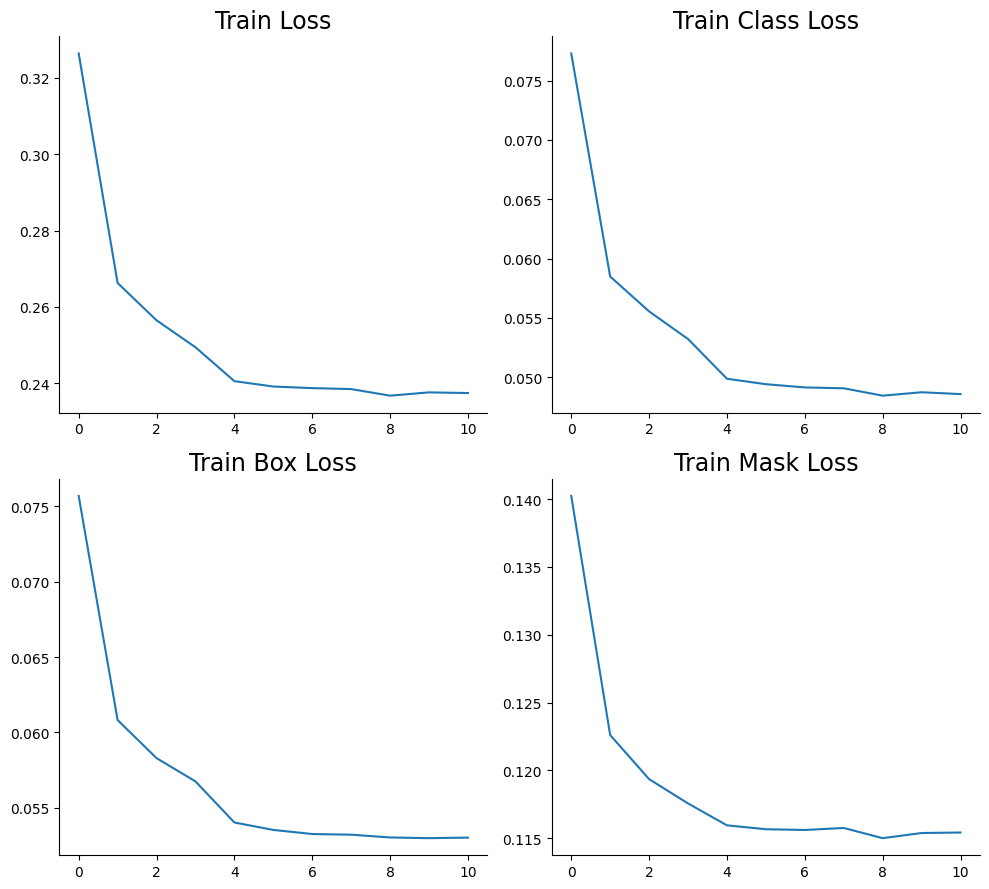

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 9))

# train_loss
axs[0][0].plot(hist_df['train_loss'])
axs[0][0].set_title('Train Loss', fontsize=17)
axs[0][0].spines[['top', 'right']].set_visible(False)

axs[0][1].plot(hist_df['train_class_loss'])
axs[0][1].set_title('Train Class Loss', fontsize=17)
axs[0][1].spines[['top', 'right']].set_visible(False)

axs[1][0].plot(hist_df['train_box_loss'])
axs[1][0].set_title('Train Box Loss', fontsize=17)
axs[1][0].spines[['top', 'right']].set_visible(False)

axs[1][1].plot(hist_df['train_mask_loss'])
axs[1][1].set_title('Train Mask Loss', fontsize=17)
axs[1][1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

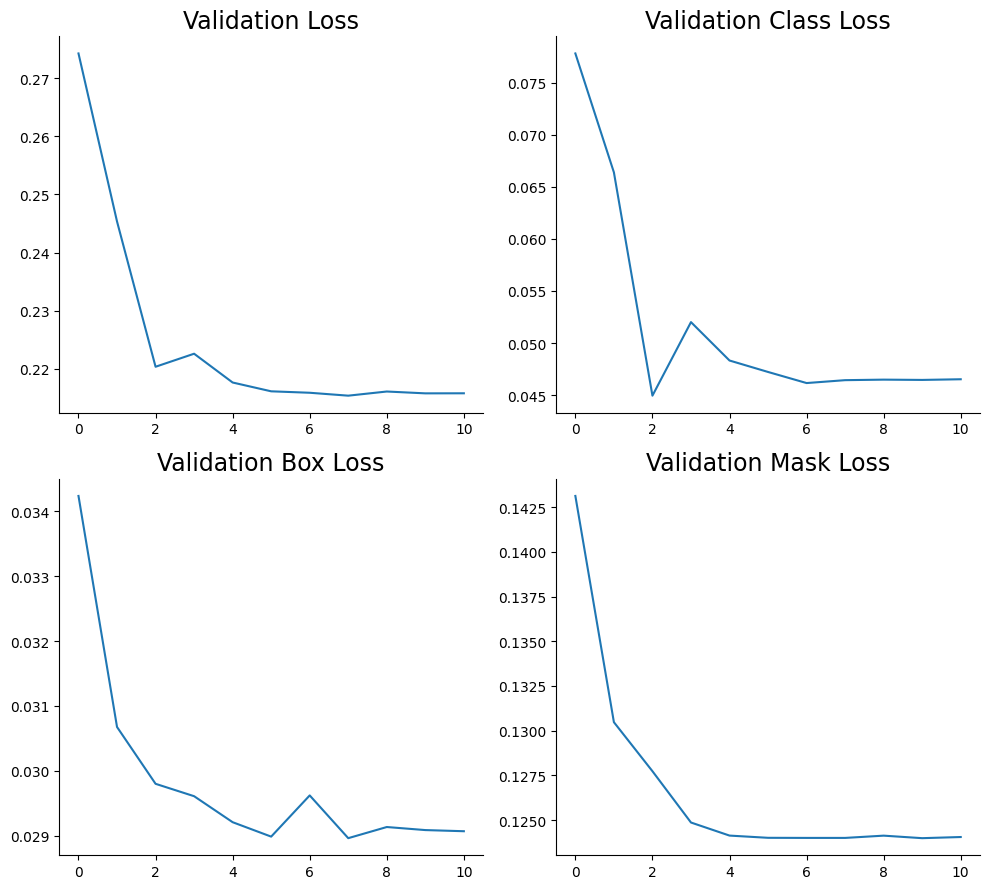

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 9))

# val_loss
axs[0][0].plot(hist_df['val_loss'])
axs[0][0].set_title('Validation Loss', fontsize=17)
axs[0][0].spines[['top', 'right']].set_visible(False)

axs[0][1].plot(hist_df['val_class_loss'])
axs[0][1].set_title('Validation Class Loss', fontsize=17)
axs[0][1].spines[['top', 'right']].set_visible(False)

axs[1][0].plot(hist_df['val_box_loss'])
axs[1][0].set_title('Validation Box Loss', fontsize=17)
axs[1][0].spines[['top', 'right']].set_visible(False)

axs[1][1].plot(hist_df['val_mask_loss'])
axs[1][1].set_title('Validation Mask Loss', fontsize=17)
axs[1][1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

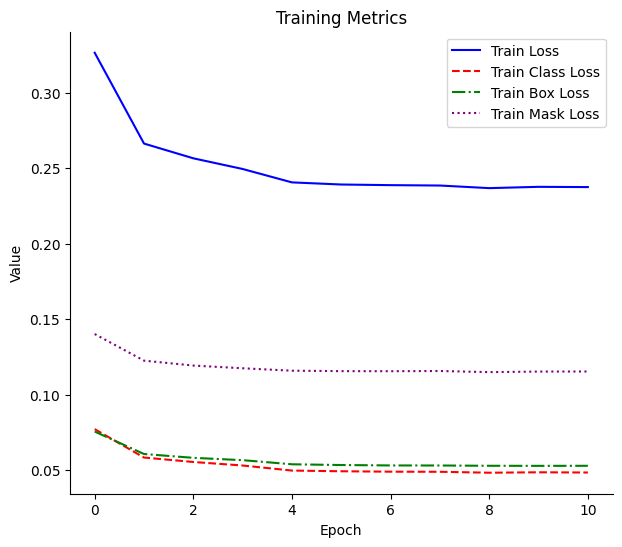

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

# 각 데이터 시리즈를 plot합니다.
ax.plot(hist_df['train_loss'], label='Train Loss', color='blue', linestyle='-')
ax.plot(hist_df['train_class_loss'], label='Train Class Loss', color='red', linestyle='--')
ax.plot(hist_df['train_box_loss'], label='Train Box Loss', color='green', linestyle='-.')
ax.plot(hist_df['train_mask_loss'], label='Train Mask Loss', color='purple', linestyle=':')

# 그래프 제목과 축 레이블을 설정합니다.
ax.set_title('Training Metrics', fontsize=12)
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')

# 범례를 추가합니다.
ax.legend()

# top과 right spines를 숨깁니다.
ax.spines[['top', 'right']].set_visible(False)

# 그래프를 출력합니다.
plt.show()

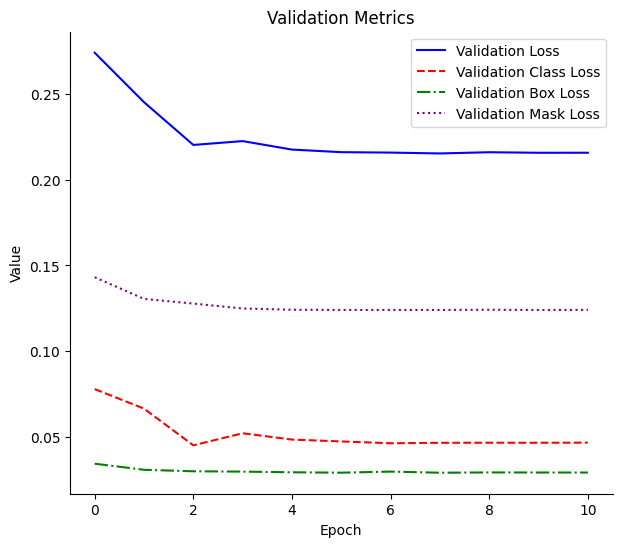

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

# 각 데이터 시리즈를 plot합니다.
ax.plot(hist_df['val_loss'], label='Validation Loss', color='blue', linestyle='-')
ax.plot(hist_df['val_class_loss'], label='Validation Class Loss', color='red', linestyle='--')
ax.plot(hist_df['val_box_loss'], label='Validation Box Loss', color='green', linestyle='-.')
ax.plot(hist_df['val_mask_loss'], label='Validation Mask Loss', color='purple', linestyle=':')

# 그래프 제목과 축 레이블을 설정합니다.
ax.set_title('Validation Metrics', fontsize=12)
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')

# 범례를 추가합니다.
ax.legend()

# top과 right spines를 숨깁니다.
ax.spines[['top', 'right']].set_visible(False)

# 그래프를 출력합니다.
plt.show()

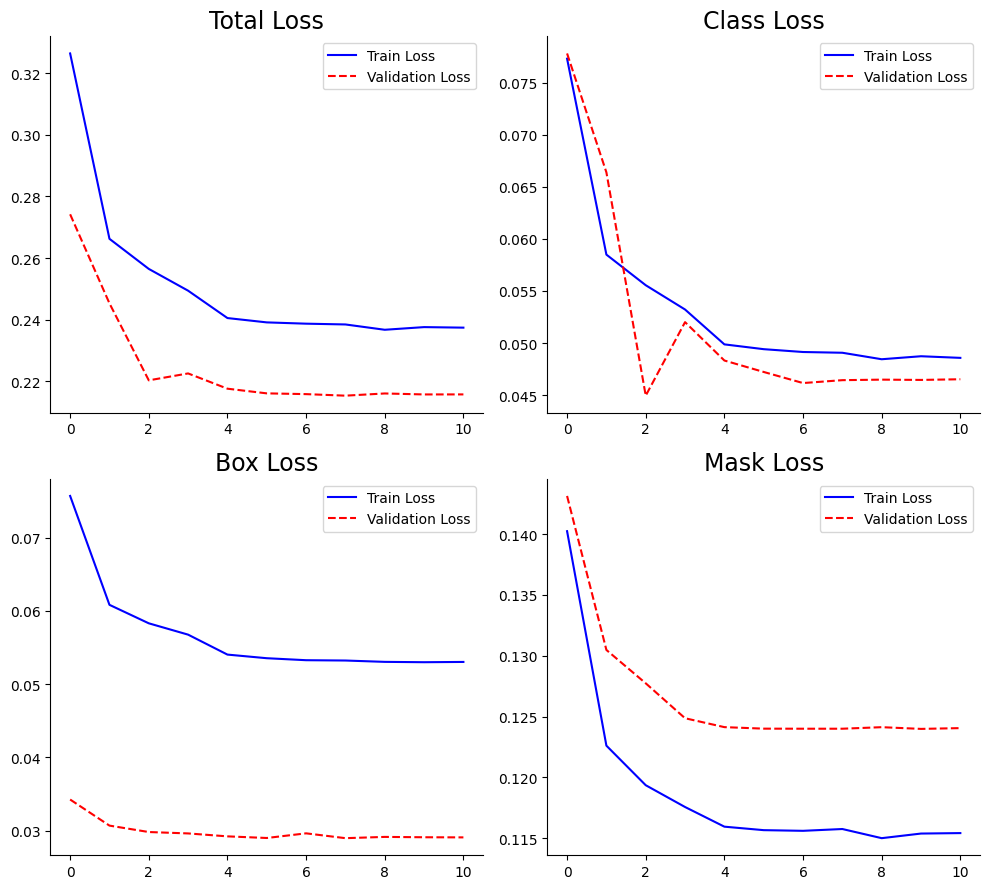

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 9))

# val_loss
axs[0][0].plot(hist_df['train_loss'], label='Train Loss', color='blue', linestyle='-')
axs[0][0].plot(hist_df['val_loss'], label='Validation Loss', color='red', linestyle='--')
axs[0][0].set_title('Total Loss', fontsize=17)
axs[0][0].spines[['top', 'right']].set_visible(False)
axs[0][0].legend()

axs[0][1].plot(hist_df['train_class_loss'], label='Train Loss', color='blue', linestyle='-')
axs[0][1].plot(hist_df['val_class_loss'], label='Validation Loss', color='red', linestyle='--')
axs[0][1].set_title('Class Loss', fontsize=17)
axs[0][1].spines[['top', 'right']].set_visible(False)
axs[0][1].legend()

axs[1][0].plot(hist_df['train_box_loss'], label='Train Loss', color='blue', linestyle='-')
axs[1][0].plot(hist_df['val_box_loss'], label='Validation Loss', color='red', linestyle='--')
axs[1][0].set_title('Box Loss', fontsize=17)
axs[1][0].spines[['top', 'right']].set_visible(False)
axs[1][0].legend()

axs[1][1].plot(hist_df['train_mask_loss'], label='Train Loss', color='blue', linestyle='-')
axs[1][1].plot(hist_df['val_mask_loss'], label='Validation Loss', color='red', linestyle='--')
axs[1][1].set_title('Mask Loss', fontsize=17)
axs[1][1].spines[['top', 'right']].set_visible(False)
axs[1][1].legend()

plt.tight_layout()
plt.show()

### 4. visualize result



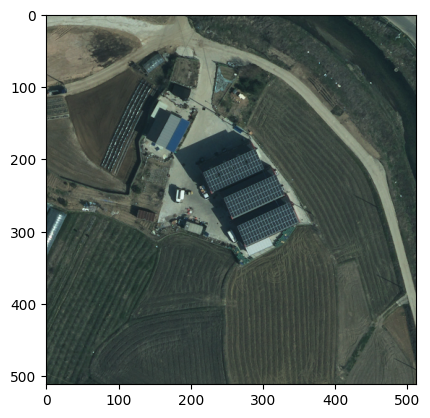

In [ ]:
model.eval()
with torch.no_grad():
    for images, targets in test_dloader:
        images = list(img.to(DEVICE) for img in images)
        outputs = model(images)

        # Display results
        for i in range(len(images)):
            # images[i].shape = torch.Size([3, 512, 512])
            # └─> img.shape = (512, 512, 3)
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            plt.imshow(img)
            plt.show()
            break
        break

In [ ]:
for idx, ins in enumerate(outputs):
    for k, v in ins.items():
        outputs[idx][k] = v.cpu().detach().numpy()
outputs[0]

{'boxes': array([[264.5599  , 260.01163 , 348.56317 , 320.8912  ],
        [216.78386 , 186.20111 , 300.94186 , 248.18481 ],
        [125.506775, 271.2496  , 152.54054 , 288.50684 ],
        [245.14597 , 222.07236 , 329.9372  , 282.11426 ],
        [245.06516 , 222.02507 , 330.0337  , 282.78    ],
        [264.46878 , 261.0105  , 348.4198  , 321.443   ],
        [215.43953 , 186.71254 , 301.64398 , 247.53175 ],
        [ 75.40076 ,  93.65527 , 144.51523 , 221.7331  ],
        [ 73.72611 ,  93.21925 , 147.8214  , 219.66026 ]], dtype=float32),
 'labels': array([1, 1, 2, 1, 2, 2, 2, 1, 2]),
 'scores': array([0.94223046, 0.93287873, 0.9278475 , 0.901788  , 0.32658786,
        0.2979484 , 0.23237671, 0.17951891, 0.16634306], dtype=float32),
 'masks': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..

In [ ]:
with open("/content/drive/MyDrive/FP/outputs.pkl", "wb") as f:
    pickle.dump(outputs, f)

In [ ]:
with open("/content/drive/MyDrive/FP/outputs.pkl", "rb") as f:
    load_outputs = pickle.load(f)
load_outputs[0]

{'boxes': array([[264.5599  , 260.01163 , 348.56317 , 320.8912  ],
        [216.78386 , 186.20111 , 300.94186 , 248.18481 ],
        [125.506775, 271.2496  , 152.54054 , 288.50684 ],
        [245.14597 , 222.07236 , 329.9372  , 282.11426 ],
        [245.06516 , 222.02507 , 330.0337  , 282.78    ],
        [264.46878 , 261.0105  , 348.4198  , 321.443   ],
        [215.43953 , 186.71254 , 301.64398 , 247.53175 ],
        [ 75.40076 ,  93.65527 , 144.51523 , 221.7331  ],
        [ 73.72611 ,  93.21925 , 147.8214  , 219.66026 ]], dtype=float32),
 'labels': array([1, 1, 2, 1, 2, 2, 2, 1, 2]),
 'scores': array([0.94223046, 0.93287873, 0.9278475 , 0.901788  , 0.32658786,
        0.2979484 , 0.23237671, 0.17951891, 0.16634306], dtype=float32),
 'masks': array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..

In [ ]:
targets

({'boxes': tensor([[217.0546, 186.4258, 301.5403, 247.0688],
          [246.0019, 221.9344, 329.9603, 282.1589],
          [263.9506, 259.9085, 349.3923, 321.1714]]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'area': tensor([5123.4658, 5056.3501, 5234.4038

In [ ]:
with open(f"/content/drive/MyDrive/FP/targets.pkl", "wb") as f:
    pickle.dump(targets, f)

In [ ]:
with open(f"/content/drive/MyDrive/FP/targets.pkl", "rb") as f:
    load_targets = pickle.load(f)
load_targets[0]

{'boxes': tensor([[217.0546, 186.4258, 301.5403, 247.0688],
         [246.0019, 221.9344, 329.9603, 282.1589],
         [263.9506, 259.9085, 349.3923, 321.1714]]),
 'labels': tensor([1, 1, 1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'area': tensor([5123.4658, 5056.3501, 5234.4038]),
 'image_id': tensor([0])

In [ ]:
type(load_targets[0]['boxes'])

torch.Tensor

#### `np.histogram2d`

`np.histogram2d` 함수는 두 개의 데이터 집합에서 2차원 히스토그램을 계산하는 데 사용됩니다. 이는 두 변수 간의 이변량 분포를 시각화하거나 분석할 때 유용합니다. 히스토그램은 데이터를 이산적인 빈(bin)으로 나누고 각 빈에 속하는 데이터의 개수를 셉니다. `np.histogram2d`는 이러한 작업을 2차원으로 확장한 것입니다.

함수의 시그니처는 다음과 같습니다:

```python
numpy.histogram2d(x, y, bins=10, range=None, normed=None, weights=None, density=None)
```

여기서 각 매개변수의 의미는 다음과 같습니다:

- `x`, `y`: 데이터 포인트의 좌표를 나타내는 배열. `x`와 `y`는 동일한 길이를 가져야 합니다.
- `bins`: 빈의 개수 또는 빈의 경계값을 지정합니다. 정수 하나로 동일한 빈 개수를 사용할 수 있고, 리스트나 배열로 각각의 축에 대해 개별적으로 지정할 수도 있습니다. 예를 들어, `bins=[10, 20]`은 x축에 10개의 빈, y축에 20개의 빈을 사용합니다.
- `range`: 각 축의 값 범위를 지정합니다. 예를 들어, `range=[[xmin, xmax], [ymin, ymax]]`와 같이 사용합니다. 기본값은 `[x.min(), x.max()]`와 `[y.min(), y.max()]`입니다.
- `normed` (더 이상 사용되지 않음): 이 매개변수는 `density`로 대체되었습니다.
- `weights`: 각 데이터 포인트에 가중치를 부여할 때 사용합니다. 기본값은 모든 가중치가 동일한 `None`입니다.
- `density`: `True`로 설정하면 결과를 확률 밀도 함수로 정규화합니다. 빈의 개수 대신 확률 밀도를 반환합니다.

함수는 다음과 같은 값을 반환합니다:
- `H`: 2차원 히스토그램 배열입니다. `H[i, j]`는 빈 `[i, j]`에 속하는 데이터 포인트의 개수입니다.
- `xedges`, `yedges`: x축과 y축의 빈 경계값을 나타내는 배열입니다.

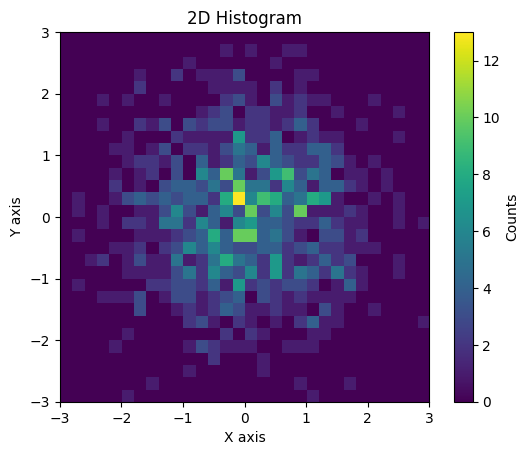

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 예제 데이터 생성
x = np.random.randn(1000)
y = np.random.randn(1000)

# 2D 히스토그램 계산
H, xedges, yedges = np.histogram2d(x, y, bins=30, range=[[-3, 3], [-3, 3]])

# 히스토그램 시각화
plt.imshow(H.T, origin='lower', extent=[-3, 3, -3, 3], cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('2D Histogram')
plt.show()

히스토그램(histogram)은 데이터의 분포를 시각적으로 나타내는 도구입니다. 주어진 데이터셋을 일정한 구간(bin)으로 나누고, 각 구간에 속하는 데이터 포인트의 개수를 세어 막대 그래프로 나타낸 것입니다. 히스토그램은 데이터의 분포, 중심 경향성, 변동성 등을 이해하는 데 유용합니다.

$\Large 히스토그램의 활용$

- **데이터 분포 분석**: 데이터가 특정 범위에 집중되어 있는지, 혹은 고르게 분포되어 있는지 확인할 수 있습니다.
- **중심 경향성 파악**: 데이터의 중앙값, 평균값 등이 어느 쪽에 위치하는지 파악할 수 있습니다.
- **변동성 분석**: 데이터가 얼마나 넓게 퍼져 있는지, 즉 분산이나 표준편차가 큰지 작은지를 파악할 수 있습니다.
- **이상치 탐지**: 히스토그램을 통해 데이터에서 극단적인 값(이상치)이 존재하는지 확인할 수 있습니다.

$\Large 히스토그램의 구성 요소$

1. **빈(bin)**: 데이터 범위를 일정한 간격으로 나눈 구간입니다. 각 빈은 데이터의 특정 구간을 나타내며, 히스토그램의 x축에 해당합니다.
2. **빈의 개수(bin count)**: 각 빈에 속하는 데이터 포인트의 개수입니다. 히스토그램의 y축에 해당하며, 각 빈의 높이로 표현됩니다.

$\Large 히스토그램 예시$

데이터가 주어졌을 때 히스토그램을 만드는 방법을 단계별로 설명하면 다음과 같습니다:

1. **데이터 수집**: 히스토그램을 작성할 데이터셋을 수집합니다.
2. **구간 설정**: 데이터 범위를 일정한 간격으로 나눕니다.
3. **빈 계산**: 각 구간에 속하는 데이터 포인트의 개수를 셉니다.
4. **시각화**: 구간을 x축, 빈의 개수를 y축으로 하여 막대 그래프로 나타냅니다.

예제에서:
- `data`는 정규 분포를 따르는 1000개의 임의의 데이터 포인트입니다.
- `plt.hist` 함수는 데이터를 30개의 빈으로 나누고 각 빈에 속하는 데이터 포인트의 개수를 계산하여 히스토그램을 그립니다.
- `bins=30`은 30개의 구간으로 나눈다는 의미입니다.
- `edgecolor='black'`은 막대의 경계선을 검은색으로 설정하여 시각적으로 구분하기 쉽게 만듭니다.

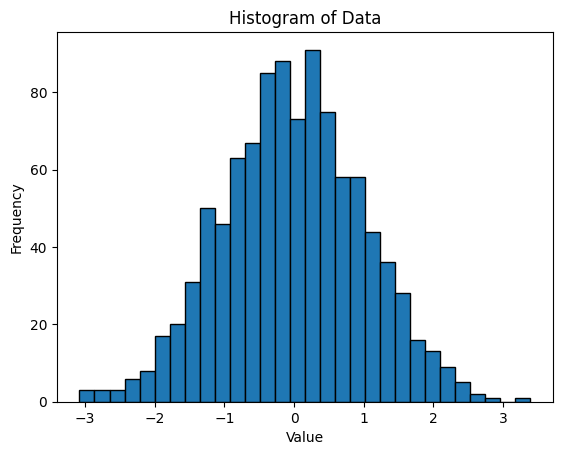

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 예제 데이터 생성
data = np.random.randn(1000)

# 히스토그램 계산 및 시각화
plt.hist(data, bins=30, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

In [ ]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt

# 예제 binary mask 생성 (여기서는 간단히 임의로 생성)
mask = np.zeros((512, 512), dtype=np.uint8)
mask[100:400, 100:400] = 1

# contour 찾기
# level=0.5는 binary mask에서 경계를 찾겠다는 의미
# Value along which to find contours in the array.
# By default, the level is set to (max(image) + min(image)) / 2
contours = measure.find_contours(mask, level=0.5)
# contours : list of (n,2)-ndarrays
# Each contour is an ndarray of shape (n, 2),
# consisting of n (row, column) coordinates along the contour
# 첫 번째 contour의 좌표 출력 (x, y) 순서로 변환
polygon_coords = [(x, y) for y, x in contours[0]]
print(len(polygon_coords), polygon_coords[0])

# 시각화
fig, ax = plt.subplots()
ax.imshow(mask, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.show()

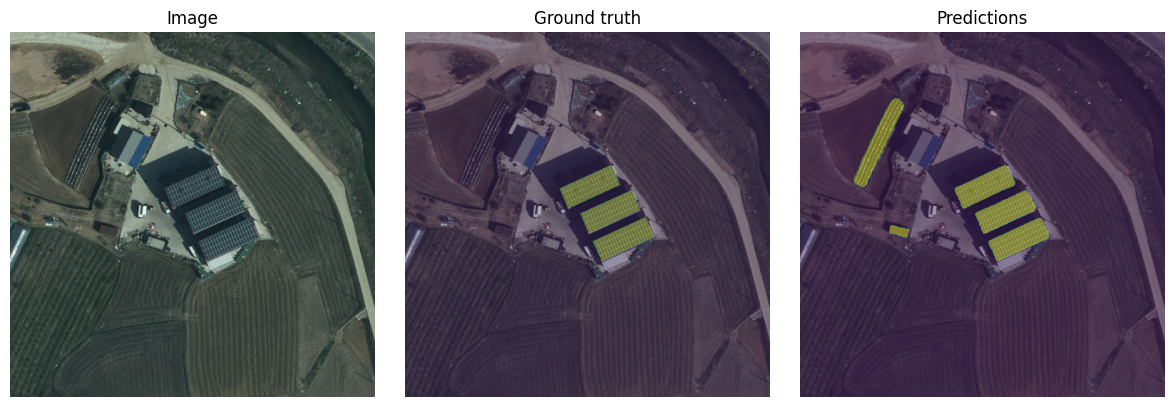

In [ ]:
def analyze_test_sample(model, ds_train, sample_index):
    plt.figure(figsize=(12, 4))

    img, targets = ds_train[sample_index]
    plt.subplot(1, 3, 1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title("Image")
    plt.axis('off')

    masks = np.zeros((512, 512))
    for mask in targets['masks']:
        masks = np.logical_or(masks, mask)
    plt.subplot(1, 3, 2)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.imshow(masks, alpha=0.3)
    plt.title("Ground truth")
    plt.axis('off')

    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]
    plt.subplot(1, 3, 3)
    plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((512, 512))
    for mask in preds['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title("Predictions")
    plt.axis('off')

    plt.savefig('analyze_test_sample.png', bbox_inches='tight', pad_inches=0.1)
    plt.tight_layout()
    plt.show()

analyze_test_sample(model, test_dataset, 0)

In [ ]:
image = Image.open(os.path.join(img_dir, img_path)).convert("RGB")
colors = random_colors(len(polygons), opencv=False)
categories = sg25_df.query(f"file_name=='{img_list[0]}'")['area'].tolist()
categories

def draw_polygon_bbox(image, polygons, categories, colors, alpha=0.5):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    for polygon, category, col in zip(polygons, categories, colors):
        # bbox
        x, y, width, height = get_bbox_from_polygon(polygon)
        rect = Rectangle(
            (x, y), width, height, linewidth=1, edgecolor=col, facecolor='none', linestyle='dotted'
        )
        ax.add_patch(rect)
        # polygon
        xy_pairs = convert_to_xy_pairs(polygon)
        poly = Polygon(xy_pairs, closed=True, edgecolor=col, facecolor=col, alpha=alpha)
        ax.add_patch(poly)
        # label
        ax.text(x+1, y+8, category, fontsize=9, color='white') # , bbox=dict(facecolor=col, alpha=alpha)

    plt.axis('off')
    plt.savefig('polygon_bbox.png', bbox_inches='tight', pad_inches=0)#, facecolor='black')
    plt.show()

### 5. model 성능 : mAP@70

In [ ]:
img, target = test_dataset[0]
img.shape, target

In [ ]:
target['image_id'].item()

In [ ]:
target['boxes'].cpu().numpy().tolist()

In [ ]:
from collections import defaultdict

ground_true = defaultdict(dict)
predictions = defaultdict(dict)

model.eval()
with torch.no_grad():
    for img, target in test_dataset:
        output = model([img.to(DEVICE)])

        ground_true[target['image_id'].item()]['boxes'] = target['boxes'].cpu().numpy().tolist()
        ground_true[target['image_id'].item()]['area'] = target['area'].cpu().numpy().tolist()
        ground_true[target['image_id'].item()]['labels'] = target['labels'].cpu().numpy().tolist()
        ground_true[target['image_id'].item()]['masks'] = target['masks'].cpu().numpy().tolist()

        for k, v in output[0].items():
            # output[k] = v.cpu().numpy().tolist()
        predictions[target['image_id'].item()] = output
        break

ground_true, predictions

## - get segment_info